In [34]:
from utils import log
from model import TinyRNN
from dataset import * 
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader

In [2]:
x=np.load('cached_data/cached_trajectories_train_nodes_[7, 11]_test_nodes_9_strategy_RolloutStrategy_num_rollouts_2_train_prob.npy',allow_pickle=True)


KeyboardInterrupt: 

In [290]:
action_seq=x[:,1]

(array([ 11567.,      0.,  97660.,      0.,      0., 157489.,      0.,
         50795.,      0.,  12943.]),
 array([5. , 5.4, 5.8, 6.2, 6.6, 7. , 7.4, 7.8, 8.2, 8.6, 9. ]),
 <BarContainer object of 10 artists>)

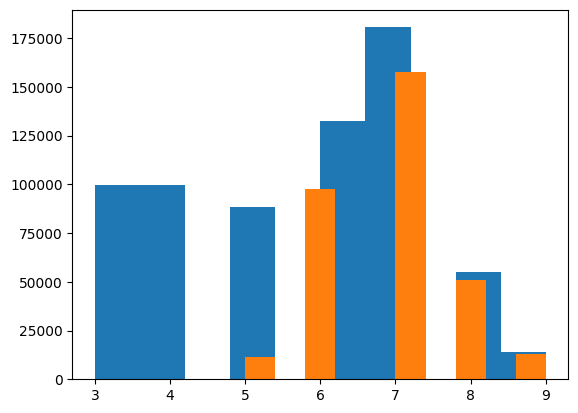

In [294]:
lengths=np.asarray([len(a) for a in action_seq])
decision=np.asarray([a[-1] for a in action_seq])
plt.figure()
plt.hist(lengths[decision==4])
plt.hist(lengths[decision==5])

In [336]:
subset=x[lengths==3,0]
cases=[]
for idx in range(len(subset)):
    if subset[idx][1,-3]<0:
        cases.append(idx)
    

In [339]:
x[lengths==3,0][4][:,-3]

array([ 0., -8.,  0.])

In [340]:
x[lengths==3,1][4]

array([0, 3, 4])

In [325]:
x[:,1]

array([array([0, 1, 1, 2, 1, 3, 4]), array([0, 2, 1, 1, 1, 3, 5]),
       array([0, 0, 2, 1, 1, 3, 5]), ..., array([0, 2, 1, 1, 0, 3, 5]),
       array([0, 0, 0, 0, 2, 1, 3, 4]), array([0, 0, 2, 1, 3, 4])],
      dtype=object)

In [331]:
o[:,-3]

array([0., 8., 0.])

In [327]:
a

array([0, 3, 4])

In [296]:
np.sum(decision==4)

669546

In [297]:
np.sum(decision==5)

330454

In [67]:
import math 
from torch import Tensor

import torch.nn.init as init 
class ElementWiseLinear(nn.Module):

    def __init__(self, num_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.num_features=num_features
        self.weight = nn.Parameter(torch.empty((num_features,1), **factory_kwargs))
        if bias:
            self.bias = nn.Parameter(torch.empty((num_features,1), **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return self.weight[:,0]*input+self.bias[:,0]

    def extra_repr(self) -> str:
        return f'features={self.num_features}, bias={self.bias is not None}'
class TinyRNN(nn.Module):
    def __init__(self,input_size=58,num_actions=23):
        super(TinyRNN,self).__init__()
        self.input_size=input_size
        self.num_action=num_actions
        #self.hidden_size=2
        self.hidden_size=self.num_action
        #self.hidden_size=2
        print("TinyRNN Specs: GRU with input size {} and hidden dim {}".format(self.input_size,self.hidden_size))
        self.rnn=nn.GRU(self.input_size,self.hidden_size,batch_first=True)
        self.pi_out=ElementWiseLinear(self.hidden_size)
        #self.pi_out=nn.Linear(self.hidden_size,self.num_action)
        #self.value_out=nn.Linear(self.hidden_size,2)
    
    def forward(self,task_seq,device,hidden=None):
        if hidden is None:
            hidden=torch.zeros(1,task_seq.shape[0],self.hidden_size)
        hidden=hidden.to(device)
        lstm_out,hidden=self.rnn(task_seq,hidden)
        action_pred=self.pi_out(lstm_out)
        return action_pred,hidden 
        #value_pred=self.value_out(lstm_out)
        #return action_pred,value_pred,hidden 
model=TinyRNN(input_size=58,num_actions=6)
model.load_state_dict(torch.load('share_model/fixed_model.pt',map_location='cpu'))

TinyRNN Specs: GRU with input size 58 and hidden dim 6


<All keys matched successfully>

In [68]:
class SupervisedTrajectoryTestDataset(Dataset):
    def __init__(self,num_node=9,size=11,strat_class=RolloutStrategy):
        self.num_node=num_node 
        self.size=size 
        self.strategy_class=strat_class
        assert self.size>=self.num_node 
        self.num_actions=len(action_dict.keys())
        env=DecisionTreeEnv(num_node)
        self.trajectories=[]
        for _ in tqdm(range(1000)):
            o,a,r=self.sample_trajectory(env)
            self.trajectories.append([o,a,r])
        self.trajectories=np.asarray(self.trajectories)
        self.obs_size=len(self.trajectories[0][0][0])
    
    def sample_trajectory(self,env):
        observations=[]
        actions=[]
        rewards=[]
        env.reset()
        strategy=self.strategy_class(env)
        obs,info=env.reset()
        done=False 
        while done==False:
            symbolic_action,env_action,info2=strategy.select_action(obs,info)
            if symbolic_action!=3:
                r=self.get_reward_from_obs(obs)
                obs=self.wrap_observation(obs)
                observations.append(obs)
                actions.append(symbolic_action)
                rewards.append(r)
            obs, reward, done, _, info=env.step(env_action)
        return np.asarray(observations),np.asarray(actions),np.asarray(rewards)
    
    def re_onehot(self,o):
        new_onehot=np.zeros(self.size)
        new_onehot[:len(o)]=o 
        return new_onehot 
    
    def get_reward_from_obs(self,obs):
        inds=[self.num_node*i for i in range(1,6)]
        for _ in range(3):
            inds.append(inds[-1]+1)
        fixation_onehot,fixation_parent_onehot,fixation_left_child_onehot,fixation_right_child_onehot,root_node_onehot,fixation_reward,timer,stage=np.split(obs,inds)[:-1]
        return fixation_reward 
    


    def wrap_observation(self,obs):
        inds=[self.num_node*i for i in range(1,6)]
        for _ in range(3):
            inds.append(inds[-1]+1)
        fixation_onehot,fixation_parent_onehot,fixation_left_child_onehot,fixation_right_child_onehot,root_node_onehot,fixation_reward,timer,stage=np.split(obs,inds)[:-1]
        fixation_onehot=self.re_onehot(fixation_onehot)
        fixation_parent_onehot=self.re_onehot(fixation_parent_onehot)
        fixation_left_child_onehot=self.re_onehot(fixation_left_child_onehot)
        fixation_right_child_onehot=self.re_onehot(fixation_right_child_onehot)
        root_node_onehot=self.re_onehot(root_node_onehot)
        return np.hstack([fixation_onehot,fixation_parent_onehot,fixation_left_child_onehot,fixation_right_child_onehot,root_node_onehot,fixation_reward,timer,stage])

    def __len__(self):
        return len(self.trajectories)
    def __getitem__(self,idx):
        return (self.trajectories[idx][0],self.trajectories[idx][1],self.trajectories[idx][2])

In [69]:

test_dataset=SupervisedTrajectoryTestDataset(num_node=9,size=11)

100%|██████████| 1000/1000 [00:01<00:00, 696.47it/s]
/tmp/ipykernel_1034299/2908736134.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.trajectories=np.asarray(self.trajectories)


In [70]:
test_env=DecisionTreeEnv(9)
test_dataset.sample_trajectory(test_env)

(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0., -4.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
          0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  2.,  2.

In [71]:
def model_inference(model,trajectory):
    hidden=torch.zeros(1,1,6)
    device=torch.device('cpu')
    preds=[]
    hiddens=[]
    
    for t in range(len(trajectory)):
        input_tensor=torch.from_numpy(trajectory[t].reshape((1,1,-1))).float()
        pred,hidden=model(input_tensor,device,hidden=hidden)
        #print(pred.shape)
        preds.append(pred.detach().numpy())
        hiddens.append(hidden.detach().numpy())
    return np.asarray(preds)[:,0,0,:],np.asarray(hiddens)[:,0,0,:]

In [72]:
test_preds=[]
test_actual=[]
test_h=[]
test_reward=[]
for i in tqdm(range(1000)):
    p,h=model_inference(model,test_dataset[i][0])
    test_preds.append(np.argmax(p,axis=1))
    test_h.append(p)
    test_actual.append(test_dataset[i][1])
    test_reward.append(test_dataset[i][2])

100%|██████████| 1000/1000 [00:00<00:00, 1302.83it/s]


In [73]:
test_preds=np.asarray(test_preds)
test_actual=np.asarray(test_actual)
test_h=np.asarray(test_h)
test_reward=np.asarray(test_reward)

/tmp/ipykernel_1034299/3211765274.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_preds=np.asarray(test_preds)
/tmp/ipykernel_1034299/3211765274.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_actual=np.asarray(test_actual)
/tmp/ipykernel_1034299/3211765274.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_h

In [ ]:
test_

(array([152.,   0., 139.,   0., 147.,   0., 201.,   0., 272.,  89.]),
 array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ]),
 <BarContainer object of 10 artists>)

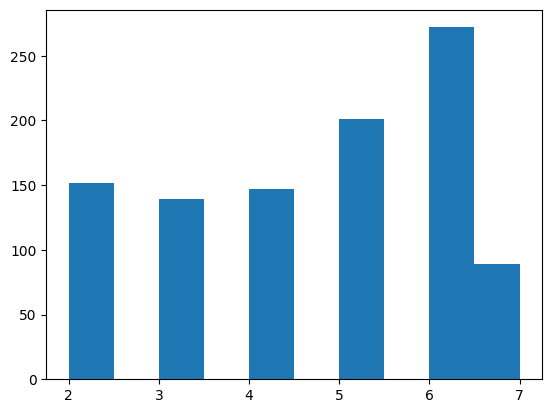

In [106]:
l=[len(test) for test in test_actual]
plt.hist(l)

Text(50.722222222222214, 0.5, 'Predicted Action')

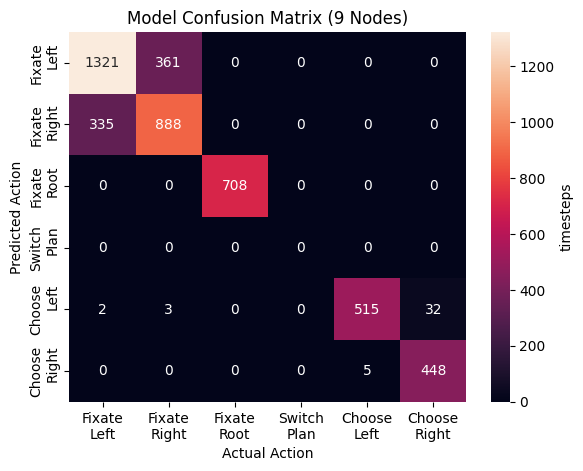

In [74]:
import seaborn as sns 
ts_wrong=[]
confusion_matrix=np.zeros((6,6))
for i in range(1000):
    for j in range(len(test_preds[i])):
        p=test_preds[i][j]
        a=test_actual[i][j]
        if (a in [4,5]) and p!=a:
            ts_wrong.append(len(test_preds[i])) 
        confusion_matrix[p,a]+=1
labels=['Fixate\nLeft','Fixate\nRight','Fixate\nRoot','Switch\nPlan','Choose\nLeft','Choose\nRight']
sns.heatmap(confusion_matrix,annot=True,fmt='g',cbar_kws={'label': 'timesteps'})
plt.title("Model Confusion Matrix (9 Nodes)")
plt.xticks(np.arange(6)+0.5,labels)
plt.yticks(np.arange(6)+0.5,labels)
plt.xlabel("Actual Action")
plt.ylabel("Predicted Action")

(array([ 9.,  0.,  5.,  0.,  0., 13.,  0., 18.,  0.,  8.]),
 array([3. , 3.4, 3.8, 4.2, 4.6, 5. , 5.4, 5.8, 6.2, 6.6, 7. ]),
 <BarContainer object of 10 artists>)

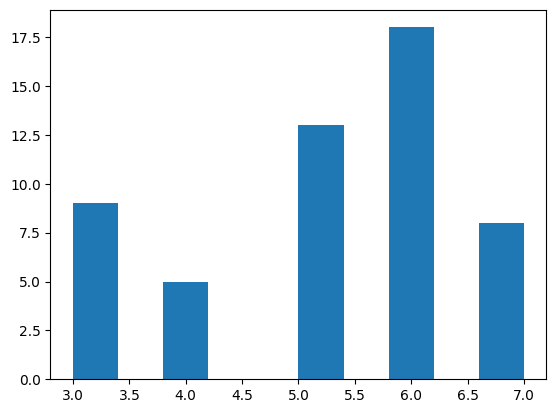

In [45]:
plt.hist(ts_wrong)

In [123]:
test_dataset[3]

(array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 2., 1.]]),
 array([0, 5]),
 array([[0.],
        [0.]]))

In [128]:
test_dataset[3][0][0][:11]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

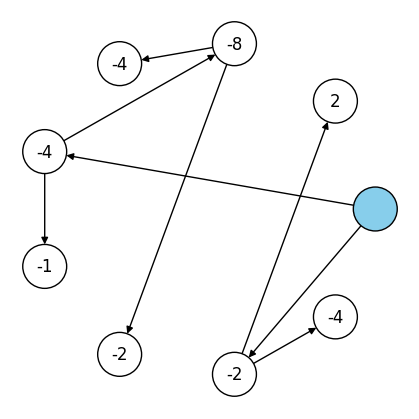

[[-5.3682113  -1.4444396 ]
 [-6.2471457   0.69962686]
 [-3.739003   -6.513114  ]
 [-3.7090003  -2.1584404 ]
 [ 2.0054832  -4.4054494 ]
 [ 7.294682   -6.1021805 ]
 [ 7.6818695  -5.5102935 ]]
[ 0. -2.  2.  0. -4. -8. -2.]
['left' 'left' 'left' 'right' 'right' 'right' 'right']
[0. 1. 2. 3. 4. 5. 6.]


In [158]:
from visualization import * 
test_env=DecisionTreeEnv(9)
def re_onehot(o,size=11):
        new_onehot=np.zeros(size)
        new_onehot[:len(o)]=o 
        return new_onehot 

def wrap_observation(obs,num_node=9,set_stage=None):
    inds=[num_node*i for i in range(1,6)]
    for _ in range(3):
        inds.append(inds[-1]+1)
    fixation_onehot,fixation_parent_onehot,fixation_left_child_onehot,fixation_right_child_onehot,root_node_onehot,fixation_reward,timer,stage=np.split(obs,inds)[:-1]
    fixation_onehot=re_onehot(fixation_onehot)
    fixation_parent_onehot=re_onehot(fixation_parent_onehot)
    fixation_left_child_onehot=re_onehot(fixation_left_child_onehot)
    fixation_right_child_onehot=re_onehot(fixation_right_child_onehot)
    root_node_onehot=re_onehot(root_node_onehot)
    if set_stage is not None:
         stage=set_stage 
    return np.hstack([fixation_onehot,fixation_parent_onehot,fixation_left_child_onehot,fixation_right_child_onehot,root_node_onehot,fixation_reward,timer,stage])


def model_fixation_inference(model,env,vis=False):
    obs,_=env.reset()
    if vis:
        visualizer = Visualizer()
        visualizer.plot(env.graph.child_dict, env.graph.rewards)

    done=False 
    hidden=torch.zeros(1,1,6)
    device=torch.device('cpu')
    visited_leafs=0
    fixation_logits=[]
    side='left'

    logits=[]
    logits2=[]
    rewards=[]
    sides=[]
    step=[]

    first=True 

    while done==False:
        
        inds=[env.num_node*i for i in range(1,6)]
        for _ in range(3):
            inds.append(inds[-1]+1)
        fixation_onehot,fixation_parent_onehot,fixation_left_child_onehot,fixation_right_child_onehot,root_node_onehot,fixation_reward,timer,stage=np.split(obs,inds)[:-1]
        fixation_onehot2=re_onehot(fixation_onehot)
        fixation_parent_onehot2=re_onehot(fixation_parent_onehot)
        fixation_left_child_onehot2=re_onehot(fixation_left_child_onehot)
        fixation_right_child_onehot2=re_onehot(fixation_right_child_onehot)
        root_node_onehot2=re_onehot(root_node_onehot)
        next_side=side 
        if np.sum(fixation_left_child_onehot)<1 and np.sum(fixation_right_child_onehot)<1:
             visited_leafs+=1
             if side=='left': 
                next_side='right'

        
        

        env_action_space=[np.argmax(fixation_left_child_onehot),np.argmax(fixation_right_child_onehot),np.argmax(root_node_onehot),env.num_node*2,env.num_node+np.argmax(fixation_left_child_onehot),env.num_node+np.argmax(fixation_right_child_onehot)]


        obs_wrapped_stage0=np.hstack([fixation_onehot2,fixation_parent_onehot2,fixation_left_child_onehot2,fixation_right_child_onehot2,root_node_onehot2,fixation_reward,timer,stage])
        obs_wrapped_stage1=np.hstack([fixation_onehot2,fixation_parent_onehot2,fixation_left_child_onehot2,fixation_right_child_onehot2,root_node_onehot2,fixation_reward,timer,1])
        
        input_tensor=torch.from_numpy(obs_wrapped_stage0.reshape((1,1,-1))).float()
        input_tensor2=torch.from_numpy(obs_wrapped_stage1.reshape((1,1,-1))).float()

        pred2,hidden2=model(input_tensor2,device,hidden=hidden)
        pred,hidden=model(input_tensor,device,hidden=hidden)
        

        original_policy=pred[0,0].detach().numpy()
        perturbed_policy=pred2[0,0].detach().numpy()

        symbolic_action=np.argmax(original_policy[:3])

        policy=original_policy.copy()
        policy[4:]=perturbed_policy[4:]

        logits.append(perturbed_policy)
        logits2.append(perturbed_policy)
        sides.append(side)
        step.append(timer)

        

        
        env_action=env_action_space[symbolic_action]
        obs, reward, done, _, info=env.step(env_action)
        rewards.append(fixation_reward)
        first=False 
        #print(done,visited_leafs,symbolic_action)
        side=next_side
        if visited_leafs>=2:
            break 
    return np.asarray(logits),np.asarray(rewards)[:,0],np.asarray(sides),np.asarray(step)[:,0]
logits,rewards,sides,step=model_fixation_inference(model,test_env,vis=True)
#logits=np.asarray([softmax(l[4:]) for l in logits])
print(logits[:,4:])
print(rewards)
print(sides)
print(step)




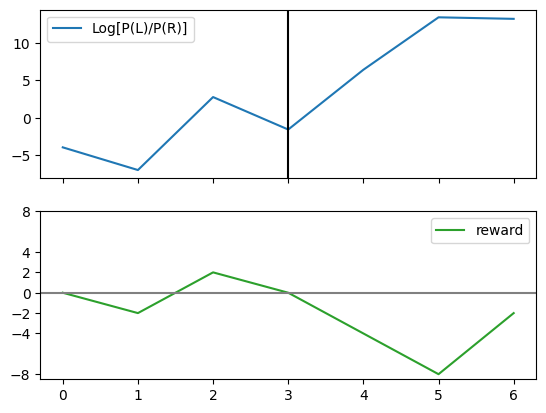

In [159]:
from scipy.special import softmax 

fig,axarr=plt.subplots(nrows=2,sharex=True)
softmaxed=np.asarray([softmax(logits[t,:])for t in range(len(logits))])
axarr[0].plot(np.log(softmaxed[:,4]/softmaxed[:,5]))
axarr[0].legend(['Log[P(L)/P(R)]'])
axarr[1].plot(rewards,color='C2')
axarr[1].legend(['reward'])
axarr[1].set_yticks([-8,-4,-2,0,2,4,8])
axarr[1].axhline(y=0.0,color='grey')
for t in range(len(logits)):
    if rewards[t]==0.0 and t>0:
        axarr[0].axvline(x=t,color='black')

In [127]:
from scipy.special import softmax 
from tqdm import tqdm 
import pandas as pd 
logit=[]
diff_logit=[]
rewards=[]
sides=[]
step=[]
acc_reward=[]

for _ in tqdm(range(1000)):
    l,r,si,st=model_fixation_inference(model,test_env)
    sm=np.asarray([softmax(l[t][4:]) for t in range(len(l))])
    ratio=np.log(sm[:,0]/sm[:,1])
    ratio_diff=np.diff(ratio)
    for t in range(len(ratio)-1):
        logit.append(ratio[t])
        diff_logit.append(ratio_diff[t])
        rewards.append(r[t])
        acc_reward.append(np.sum(r[:t]))
        sides.append(si[t])
        step.append(st[t])

df=pd.DataFrame(dict(logit=logit,delta=diff_logit,reward=rewards,sides=sides,step=step,acc_reward=acc_reward))
    

100%|██████████| 1000/1000 [00:03<00:00, 258.41it/s]


In [129]:
logit=np.asarray(logit)
diff_logit=np.asarray(diff_logit)
reward=np.asarray(rewards)
sides=np.asarray(sides)
step=np.asarray(step)
acc_reward=np.asarray(acc_reward)
df2=pd.DataFrame(dict(logit=logit[:-1],delta=diff_logit[:-1],reward=rewards[1:],sides=sides[:-1],step=step[:-1],acc_reward=acc_reward[1:]))

Text(0, 0.5, 'Delta L(t+1) - L(t)')

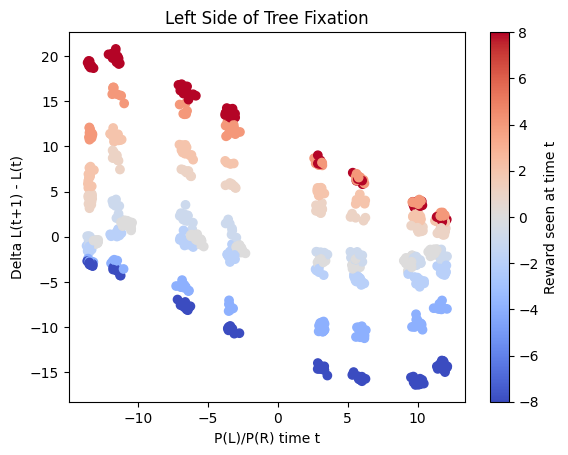

In [130]:

sub_df=df2[(df2['sides']=='left')&(df2['step']==1.0)]
plt.scatter(sub_df['logit'],sub_df['delta'],c=sub_df['reward'],cmap='coolwarm')
cbar=plt.colorbar()
cbar.set_label('Reward seen at time t')
plt.title("Left Side of Tree Fixation")
plt.xlabel("P(L)/P(R) time t")
plt.ylabel("Delta L(t+1) - L(t)")


Text(0, 0.5, 'Delta L(t+2) - L(t+1)')

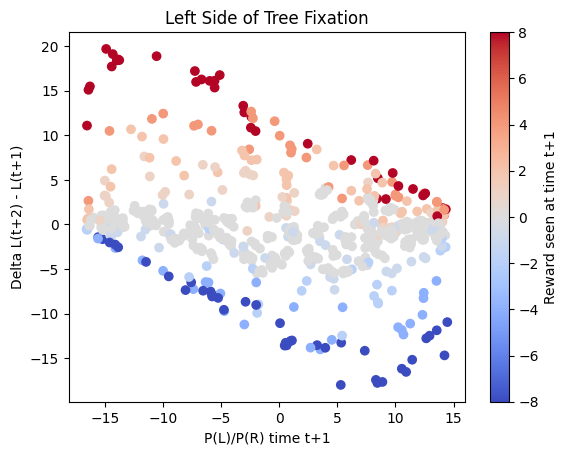

In [131]:

sub_df=df2[(df2['sides']=='left')&(df2['step']==2.0)]
plt.scatter(sub_df['logit'],sub_df['delta'],c=sub_df['reward'],cmap='coolwarm')
cbar=plt.colorbar()
cbar.set_label('Reward seen at time t+1')
plt.title("Left Side of Tree Fixation")
plt.xlabel("P(L)/P(R) time t+1")
plt.ylabel("Delta L(t+2) - L(t+1)")


In [140]:
from scipy.special import softmax 
from tqdm import tqdm 
import pandas as pd 
logit=[]
diff_logit=[]
rewards=[]
sides=[]
step=[]
acc_reward=[]

for _ in tqdm(range(1000)):
    l,r,si,st=model_fixation_inference(model,test_env)
    sm=np.asarray([softmax(l[t][4:]) for t in range(len(l))])
    ratio=np.log(sm[:,0]/sm[:,1])
    for t in range(len(ratio)-2):
        logit.append(ratio[t])
        diff_logit.append(ratio[t+2]-ratio[t])
        rewards.append(r[t+1]+r[t+2])
        acc_reward.append(np.sum(r[:t]))
        sides.append(si[t])
        step.append(st[t])

df=pd.DataFrame(dict(logit=logit,delta=diff_logit,reward=rewards,sides=sides,step=step,acc_reward=acc_reward))
    

100%|██████████| 1000/1000 [00:03<00:00, 257.40it/s]


In [141]:
df

,logit,delta,reward,sides,step,acc_reward
0,-3.817315,15.997094,6.0,left,0.0,0.0
1,5.784985,4.810688,4.0,left,1.0,0.0
2,12.179779,-1.309824,-2.0,left,2.0,2.0
3,-3.832062,4.582523,0.0,left,0.0,0.0
4,6.166264,-6.033777,-2.0,left,1.0,0.0
...,...,...,...,...,...,...
4169,9.673389,-11.957740,10.0,right,4.0,6.0
4170,-4.016379,-5.353037,-4.0,left,0.0,0.0
4171,-10.628642,17.358019,-8.0,left,1.0,0.0
4172,-9.369416,19.535778,-12.0,right,2.0,-4.0


Text(0, 0.5, 'Delta L(t+2) - L(t)')

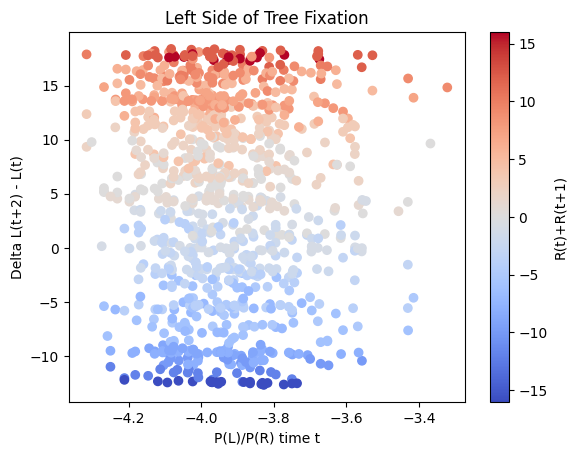

In [144]:

sub_df=df[(df['sides']=='left')&(df['step']==0)]
plt.scatter(sub_df['logit'],sub_df['delta'],c=sub_df['reward'],cmap='coolwarm')
cbar=plt.colorbar()
cbar.set_label('R(t)+R(t+1)')
plt.title("Left Side of Tree Fixation")
plt.xlabel("P(L)/P(R) time t")
plt.ylabel("Delta L(t+2) - L(t)")
